---
title: Solving OLS regression with linear algebra  
date: 2020-07-13   
comments: false  
tags: maths, linear algebra, python  
keywords: python, data science, linear algebra, linear regression, normal equation, least squares, numpy

---

When I first learned least-squares linear regression in my undergrad degree, I remember that we approached it in the "calculus" way: taking the sum of the squared differences for each observation and solving a massive (and tedious) equation until we arrived at our coefficients and line of best fit. I actually had no idea there was an alternative way of calculating OLS regression until I completed Andrew Ng's brilliant [Machine Learning](https://www.coursera.org/learn/machine-learning/home/welcome) course on Coursera, and while taking my linear algebra unit I fully understood how it works. I'll go through the logic and calculations in this blog post, and hopefully you will see how much more elegant it is than the more traditional approach. This blog post will assume some basic understanding of matrix operations: if you'd like to get an overview of these, feel free to look at my earlier blog posts [here]({filename}2020-06-01-matrices-addition-subtraction-and-multiplication.md), [here]({filename}2020-06-15-matrix-inversion.md) and [here]({filename}2020-06-29-matrices-powers-and-transposition.md). It will also assume familiarity with OLS regression.

Say we are trying to predict students' test scores (out of 10), and the one measurement we have is the average number of hours of study they did a day for this test. Let's also say (in order to keep the calculations under control) that we only have 3 observations. Our dataset therefore looks like this:

| Hours of study ($x_1$) | Test score ($y$) |
|---------------------|----------------|
| 1 | 3 |
| 2 | 6 |
| 3 | 7 |

We believe there is some underlying relationship between these variables, which can be modelled in the form of a line $y = b_0 + b_1x_1$, where $b_0$ and $b_1$ are the intercept and the $x_1$ coefficient respectively. However, when we plot our points, we can see that no straight line would go through all 3 of our points. Instead, looking ahead a bit, we can see that linear regression instead attempts to fit a line that is as close as possible to each of the points we have observed.

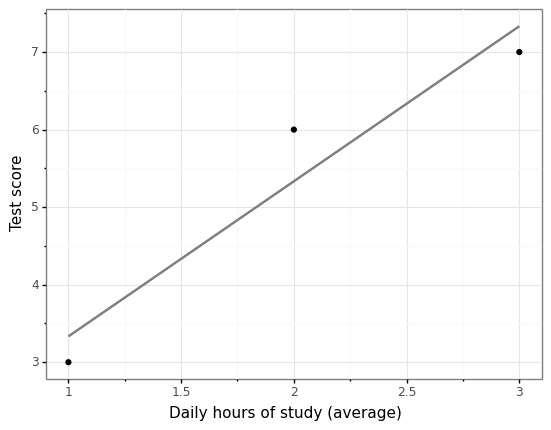

<ggplot: (312482481)>

In [35]:
from plotnine import *
from plotnine import ggplot
import pandas as pd

test_data = pd.DataFrame({"hours_study": [1, 2, 3],
                          "test_score": [3, 6, 7]})

(ggplot(test_data, aes("hours_study", "test_score")) 
    + geom_point()
    + geom_smooth(method = "lm", se = False, colour = "grey")
    + xlab("Daily hours of study (average)")
    + ylab("Test score")
    + theme_bw()
)

<img src="/figure/normal_equation_1.png" title="Linear regression trend" style="display: block; margin: auto;" />

We can see this clearly from a mathematical viewpoint as well. Each of our points will lie on the line $y = b_0 + b_1x_1$ only under the following conditions: if $b_0 + b_1 \cdotp 1 = 3$, the first observation is on the line; if $b_0 + b_1 \cdotp 2 = 6$, the second observation is on the line; and if $b_0 + b_1 \cdotp 3 = 7$ the third observation is on the line.

We can see for the first 2 observations, we have a perfect fit, where the coefficients $b_0 = 0$ and $b_1 = 3$ would solve our equations. However, the third observation throws this solution out the window. In fact, there is _no_ pair of $b_0$ and $b_1$ that will solve this equation. So what do we do? Obviously linear regression comes up with solutions to this issue all the time, so it must be solvable! I will demonstrate how using the [normal equation](http://mlwiki.org/index.php/Normal_Equation#Least_Squares) approach.

## Solving for $\hat y$ instead of $y$

In order to get started, let's move away from the world of equations and instead start representing our data as matrices and vectors. We have three components we want to represent: the values of our features ($X$), the values of our outcome ($y$), and the unknown $b_0$ and $b_1$ that we'd like to solve for ($b$).
$$
X = \begin{bmatrix} 1 & 1 \\ 1 & 2 \\ 1 & 3 \end{bmatrix} \quad\quad b = \begin{bmatrix} b_0 \\ b_1 \end{bmatrix}\quad\quad y = \begin{bmatrix} 3 \\ 6 \\ 7 \end{bmatrix}
$$

We've added a column of `1`'s to the `X` matrix (also called the [design matrix](https://en.wikipedia.org/wiki/Design_matrix)) in order to represent our intercept. This is because the value of $x_0$ in any linear equation is always set to 1, in order to hold the intercept at a constant. Now let's have a look at what these matrices and vectors represent in linear algebra. 

$X$ represents the [basis](https://en.wikipedia.org/wiki/Basis_(linear_algebra)) of a [column space](https://en.wikipedia.org/wiki/Row_and_column_spaces) $C(X)$ in $\mathbb{R}^3$. What this means is that the two columns of $X$, the vectors $(1, 1, 1)$ and $(1, 2, 3)$, lie on a [plane](https://en.wikipedia.org/wiki/Plane_(geometry)) in 3-dimensional space. We can represent all vectors on that plane by taking the linear combinations of these two vectors; that is, by getting all solutions to:

$$
C(X) = p\begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix} + q\begin{bmatrix} 1 \\ 2 \\ 3 \end{bmatrix}
$$

where $p$ and $q$ represent any real numbers. The reason that we cannot solve our three equations with the $y$ that we have from our data is that it does not lie on this plane: in other words, it is not a linear combination of our two column vectors in $X$. We can see this in the diagram below.

<img src="/figure/linear-algebra-3.png" title="y in relation to C(X)" style="display: block; margin: auto;" />

In order to solve our three equations, we need to find the _closest_ vector to $y$ in this plane $C(X)$, $\hat y$. Now, instead of trying to solve $Xb = y$, we will try to solve for $Xb = \hat y$:

$$
Xb = \hat y = \begin{bmatrix} 1 & 1 \\ 1 & 2 \\ 1 & 3 \end{bmatrix} \begin{bmatrix} b_0 \\ b_1 \end{bmatrix} = \begin{bmatrix} \hat y_1 \\ \hat y_2 \\ \hat y_3 \end{bmatrix}
$$


It turns out that the shortest path from our vector $y$ to the plane $C(X)$ is a straight line which sits at a 90° angle to the plane and connects the plane to the vector. The point where this line meets the plane is $\hat y$, the nearest approximation in the plane we have to our observed $y$, and the line itself is our error, $e$, which represents how far away our approximation $\hat y$ is from our actual $y$ vector.

<img src="/figure/linear-algebra-4.png" title="Projection of y onto C(X) to get e and y-hat" style="display: block; margin: auto;" />

The values of the vector $b$ ($b_0$ and $b_1$) turn out to be those values that give us the right linear combinations of the column vectors of $X$ in order to find this vector $\hat y$.

## Finding $b_0$ and $b_1$

So how do we find these right values of $b_0$ and $b_1$ to give us our best approximation $\hat y$? As said above, the line with the smallest distance between the plane and $y$ sits at a 90° angle to the plane: in other words, it is [orthogonal](https://en.wikipedia.org/wiki/Orthogonality#Euclidean_vector_spaces) to the plane. In fact, $e$ is not just orthogonal to our column vectors in $X$, it is orthogonal to **every** vector in $C(X)$.

Pairs of orthogonal vectors have a very nice property: when we take their [dot product](https://www.mathsisfun.com/algebra/vectors-dot-product.html), we get $0$. This means that $e$ multiplied by any vector in $C(X)$ will be $0$. Generalising this to the whole matrix X, we get:

$$
X^T \cdotp e = 0
$$

which represents that the dot product of every transposed column in $X$ multiplied by $e$ is 0. Next, because $\hat y = Xb$, and $e$ is the difference between $y$ and $\hat y$, we can rewrite the above as:

$$
X^T(y - Xb) = 0
$$

When we expand this equation and move one of the components to the righthand side, we end up with the equation that will allow us to find our $b$'s:

$$
X^TXb = X^Ty
$$

This equation will give us a new set of linear equations. If we solve these for $b_0$ and $b_1$, then we will get the right coefficients to find $\hat y$, our closest vector to $b$ that lies in $C(X)$.

Let's see this in action with our example dataset. For the lefthand side, we want to calculate our new matrix $X^TX$.

In [42]:
import numpy as np

X = np.array([[1, 1], [1, 2], [1, 3]])
X_T_X = X.transpose().dot(X)
X_T_X

array([[ 3,  6],
       [ 6, 14]])

For the righthand side, we want to calculate our new vector $X^Ty$.

In [43]:
y = np.array([[3], [6], [7]])
X_T_y = X.transpose().dot(y)
X_T_y

array([[16],
       [36]])

We can now put these together to create our new system of simultaneous equations, and solve these for $b_0$ and $b_1$.

$$
X^TXb = X^Ty = \begin{bmatrix} 3 & 6 \\ 6 & 14 \end{bmatrix} \begin{bmatrix} b_0 \\ b_1 \end{bmatrix} = \begin{bmatrix} 16 \\ 36 \end{bmatrix}
$$

This yields the two solvable equations:

$$
\begin{aligned}
3b_0 + 6b_1 &= 16 \\
6b_0 + 14b_1 &= 36
\end{aligned}
$$

Solving these, we get $b_0 = \frac{4}{3}$ and $b_1 = 2$. We now have a line of best fit, $\hat y = \frac{4}{3} + 2b_1$.

Substituting these values into $Xb$ will give us $\hat y$:

$$
\begin{aligned}
\hat y = Xb = \begin{bmatrix} 1 & 1 \\[4pt] 1 & 2 \\[4pt] 1 & 3 \end{bmatrix} \begin{bmatrix} \frac{4}{3} \\[4pt] 2 \end{bmatrix} = \begin{bmatrix} \frac{4}{3} \\[4pt] \frac{4}{3} \\[4pt] \frac{4}{3} \end{bmatrix} + \begin{bmatrix} 2 \\[4pt] 4 \\[4pt] 6 \end{bmatrix} = \begin{bmatrix} \frac{10}{3} \\[4pt] \frac{16}{3} \\[4pt] \frac{22}{3} \end{bmatrix}
\end{aligned}
$$

We can now get $e$ as well, by calculating:

$$
e = y - \hat y = \begin{bmatrix} 3 \\[4pt] 6 \\[4pt] 7 \end{bmatrix} - \begin{bmatrix} \frac{10}{3} \\[4pt] \frac{16}{3} \\[4pt] \frac{22}{3} \end{bmatrix} = \begin{bmatrix} -\frac{1}{3} \\[4pt] \frac{2}{3} \\[4pt] -\frac{1}{3} \end{bmatrix}
$$

Each of the components of $e$ represents the vertical distance between our line of best fit and our observed $y$, as shown in the graph at the beginning of this post. For example, $y_1$ "misses" the line by $-\frac{1}{3}$ of a test score grade.

We can confirm that $e$ is indeed orthogonal to $C(X)$ by picking any vector from that space and calculating its dot product with $e$. Let's try this out with $(1, 2, 3)$:

In [38]:
x_1 = np.array([[1], [2], [3]])
e = np.array([[-1/3], [2/3], [-1/3]])
x_1.transpose().dot(e)

array([[0.]])

## Confirming our result

Finally, let's compare the result we got from our normal equation approach to the result given by `sklearn`'s implementation of linear regression. Let's start by fitting our model, with the $X$ and $y$ matrices we defined above:

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)

We'll retrieve the model intercept ($b_0$) and $x_1$ coefficient ($b_1$) estimates:

In [62]:
print(f"Model intercept (b_0): {reg.intercept_}")
print(f"Model coefficient (b_1): {reg.coef_}")

Model intercept (b_0): [1.33333333]
Model coefficient (b_1): [[0. 2.]]


Finally, we'll use this model to predict the best fitting values from $X$, that is, to generate $\hat y$:

In [64]:
print(f"Generate y-hat:\n {reg.predict(X)}") 

Generate y-hat:
 [[3.33333333]
 [5.33333333]
 [7.33333333]]


We can see that our use of the normal method has achieve the exact same values given by the standard Python implementation of linear regression!